# Machine Learning in Python - Workshop 4

## 1. Setup

### 1.1 Packages

In the cell below we will load the core libraries we will be using for this workshop and setting some sensible defaults for our plot size and resolution. 

In [ ]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

### 1.2 Data

To start we will again be using the same data set from Workshop 3, which was generated via a random draw from a Gaussian Process model. It represent an unknown smooth function $f(x)$ that is observed with noise such that $y_i = f(x_i) + \epsilon_i$. The data have been randomly thinned to include only 100 observations.

We can read the data in from `gp.csv` and plot the data to see the overall trend in the data,

<AxesSubplot:xlabel='x', ylabel='y'>

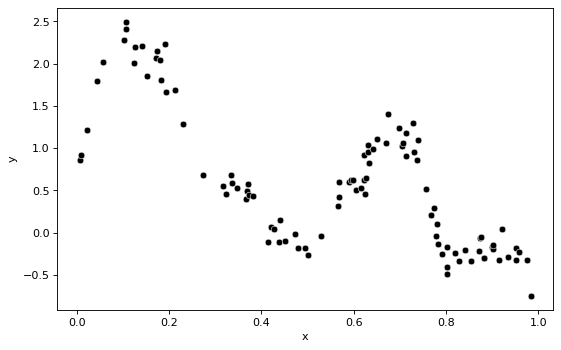

In [ ]:
d = pd.read_csv("gp.csv")
n = d.shape[0] # number of rows

sns.scatterplot(x='x', y='y', data=d, color="black")

# 2. Cross validation

In this section we will explore some of the tools that sklearn provides for cross validation for the purpose of model evaluation and selection. The most basic form of CV is to split the data into a testing and training set, this can be achieved using `train_test_split` from the `model_selection` submodule. Here we provide the function with our model matrix $X$ and outcome vector $y$ to obtain a test and train split of both.

In [ ]:
from sklearn.model_selection import train_test_split

X = np.c_[d.x]
y = d.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

The additional arguments `test_size` determines the proportion of data to include in the test set and `random_state` is the seed used when determining the partition assignments (keeping the seed the same will result in the same partition(s) each time this cell is rerun).

We can check the dimensions of the original and new objects using their shape attributes,

In [ ]:
print("orig sizes :", X.shape, y.shape)
print("train sizes:", X_train.shape, y_train.shape)
print("test sizes :", X_test.shape, y_test.shape)

orig sizes : (100, 1) (100,)
train sizes: (60, 1) (60,)
test sizes : (40, 1) (40,)


With these new objects we can try several polynomial regression models, with different values of `M`, and compare their performance. Our goal is to fit the models using the training data and then evaluating their performance using the test data so that we can avoid potential overfitting.

We will assess the models' performance using root mean squared error, 

$$ \text{rmse} = \left( \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 \right)^{1/2} $$

with sklearn this is calculated using the `mean_squared_error` function with the argument `squared=False`. This metric is entirely equivalent to mean squared error for purposes of ranking / ordering models (as the square root is a monotonic transformation) but the rmse is often prefered as it is more interpretable, as it has the same units as $y$.

The following code uses a `for` loop to fit 30 polynomial regression models with $M = [1,2,\ldots,30]$ and calculates the rmse of the training data and the testing data for each model. Note that we are fitting the model *only* using the `train` split and predicting using both the `train` and the `test` split to get the train and test rmses respectively.

In [ ]:
degree = []
train_rmse = []
test_rmse = []

M = 30

for i in np.arange(1, M+1):
    m = make_pipeline(
        PolynomialFeatures(degree=i),
        LinearRegression(fit_intercept=False)
    ).fit(X_train, y_train)
    
    degree.append(i)
    train_rmse.append(mean_squared_error(y_train, m.predict(X_train), squared=False))
    test_rmse.append(mean_squared_error(y_test, m.predict(X_test), squared=False))

fit = pd.DataFrame(data = {"degree": degree, "train_rmse": train_rmse, "test_rmse": test_rmse})

We can then plot `degree` vs `rmse` for these splits and observe the resulting pattern.

<AxesSubplot:xlabel='degree', ylabel='value'>

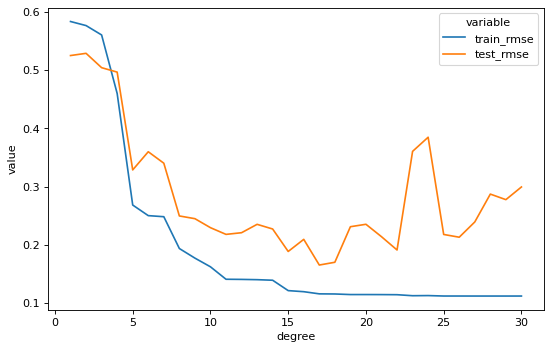

In [ ]:
sns.lineplot(x="degree", y="value", hue="variable", data = pd.melt(fit,id_vars=["degree"]))

---

### &diams; Exercise 1

Based on these results, what value of $M$ produces the best model, justify your answer.

*It looks like the test rmse reaches a minimum around a degree of 17. Other large degree values pruduce
rmses that are roughly equivalent, so all else being equal we should select the simpler mode, i.e. the model
with fewer parameters.* 

---

### &diams; Exercise 2

Try adjusting the proportion of the data in the test vs training data, how does this change the Training and Testing rmse curves?

*Changing the proportion does lead to the curves changing, particularly the test rmse, but generally the pattern seems consistent, 
with the "best" model having a degree of around 17.*

---

## 2.1 k-fold cross validation

The basic implementation of k-fold cross validation is provided by `KFold` in the `model_selection` submodule of `sklearn`. This function / object behaves in a similar way to the other `sklearn` tools we've seen before, we use the function to construct an object with some basic options and the resulting object then can be used to interact with our data / model matrix.

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5)

Here we have set up the object `kf` to implement 5-fold cross validation for our data, which we can then apply using the `split` method on our model matrix `X` and response vector `y`.

In [ ]:
kf.split(X, y)

<generator object _BaseKFold.split at 0x7f11e97edd50>

This returns a [generator](https://wiki.python.org/moin/Generators) which is then used to generate the indexes of the training data and test data for each fold. We can use list comprehension with this generator to view these values.

In [ ]:
[train for train, test in kf.split(X, y)]

[array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
        88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
        71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 

In [ ]:
[test for train, test in kf.split(X, y)]

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39]),
 array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
        57, 58, 59]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
        77, 78, 79]),
 array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
        97, 98, 99])]

---

### &diams; Exercise 3

Examine the index values that make up the test and training sets, do you notice anything intesting about how `KFold` has divided up the data?

*The fold partitions are sequential, e.g. fold 1 is 0,1,...,19; fold 2 is 20,...,39; and so on.*

---

### &diams; Exercise 4

Does the structure in Exercise 3 have any implications for model evaluation? Specifically, are the data in the different folds independent of each other, explain why this is important.

*This is problematic for our model as our data is sorted over the x values, as such the folds represent 
the first 20 observations, and the next and so on. Given we are modeling a smooth function these observations
and folds will not be independent of each other and this will signficantly affect our ability to accurately fit
a model.*

---

Using a `for` loop with the `KFold` generator it is then possible to create test and train subsets, fit the model of interest and calculate the training and testing metrics but this requires a fair bit of book keeping code to implement, see an example of this [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

However, `sklearn` provides a more convenient way of doing all of this using the  `cross_val_score` function from the `model_selection` submodule. This function takes as arguments our model or pipeline (any object implementing `fit`) and then our full model matrix $X$ and response $y$. The argument `cv` is a cross-validation generator that determines the splitting strategy (e.g. a `KFold` object).

In [ ]:
from sklearn.model_selection import cross_val_score

model = make_pipeline(
    PolynomialFeatures(degree=1),
    LinearRegression(fit_intercept=False)
)

# Use shuffle to avoid the issue seen w/ Ex. 3 & 4
# random_state again sets a random seed so we get the same results each time this cell is run
kf = KFold(n_splits=5, shuffle=True, random_state=0)
cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error")

array([-0.53205832, -0.49736481, -0.66842376, -0.54219565, -0.570626  ])

Here we have used `"neg_root_mean_squared_error"` as our scoring metric which returns the negative of the root mean squared error. As the name implies this returns the negative of the usual fit metric, this is because sklearn expects to always optimize for the maximum of a score and the model with the largest negative rmse  will therefore be the "best". To get a list of all available scoring metrics for `cross_val_score` you can run `sorted(sklearn.metrics.SCORERS.keys())`.

To obtain these 5-fold CV estimates of rmse for our models we slightly modify our original code as follows,

In [ ]:
degree = []
test_mean_rmse = []
test_rmse = []

M = 30
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for i in np.arange(1,M+1):
    model = make_pipeline(
        PolynomialFeatures(degree=i),
        LinearRegression(fit_intercept=False)
    )
    cv = -1 * cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error")
    degree.append(i)
    test_mean_rmse.append(np.mean(cv))
    test_rmse.append(cv)

cv = pd.DataFrame(
    data = np.c_[degree, test_mean_rmse, test_rmse],
    columns = ["degree", "mean_rmse"] + ["fold" + str(i) for i in range(1,6) ]
)

This fits $5 \times 30$ polynomial regression models for and stores the results in the data frame `cv`. The `mean_rmse` column contains the average rmse across all 5 folds.

In [ ]:
cv.head(n=15)

,degree,mean_rmse,fold1,fold2,fold3,fold4,fold5
0,1.0,0.562134,0.532058,0.497365,0.668424,0.542196,0.570626
1,2.0,0.563810,0.524406,0.523596,0.670822,0.537015,0.563210
2,3.0,0.565059,0.534363,0.469241,0.800306,0.499975,0.521408
3,4.0,0.518660,0.473563,0.502625,0.616382,0.531899,0.468832
4,5.0,0.303684,0.326807,0.331068,0.312491,0.305007,0.243048
5,6.0,0.316684,0.336668,0.371119,0.325595,0.310843,0.239193
6,7.0,0.299734,0.297164,0.320832,0.346016,0.304593,0.230064
7,8.0,0.239039,0.259276,0.190588,0.323880,0.288796,0.132657
8,9.0,0.215289,0.261407,0.205739,0.216862,0.270135,0.122302
9,10.0,0.224875,0.250260,0.170494,0.336424,0.248162,0.119036


We can now plot these data, to assess the different models and their performance on fitting these data.

<AxesSubplot:xlabel='degree', ylabel='mean_rmse'>

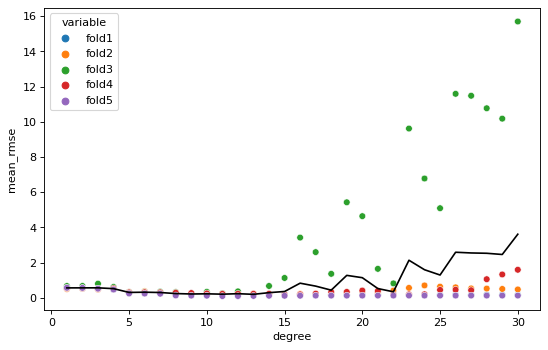

In [ ]:
sns.lineplot(x="degree", y="mean_rmse", data = cv, color="black")
sns.scatterplot(x="degree", y="value", hue="variable", data = pd.melt(cv,id_vars=["degree", "mean_rmse"]))

The plot above is a bit hard to read and compare, particularly for the lower degree polynomial models. We can address this by using a log scale for the y-axis.

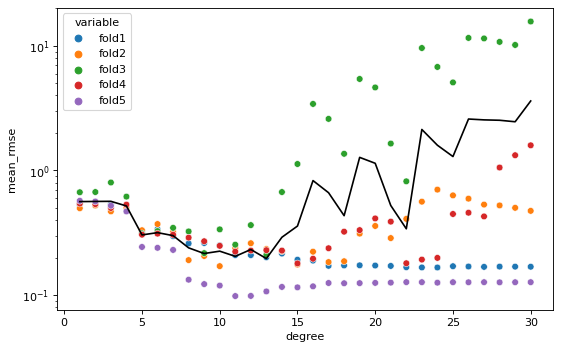

In [ ]:
g = sns.lineplot(x="degree", y="mean_rmse", data = cv, color="black")
g = sns.scatterplot(x="degree", y="value", hue="variable", data = pd.melt(cv,id_vars=["degree", "mean_rmse"]))

g.set_yscale("log")

---

### &diams; Exercise 5

Do these CV rmse's agree with the results we obtained when using `train_test_split`? How do they differ, is it only a single fold that differs or several?

*Some of the individual folds look similar to the previous results, e.g. fold 1. However, there is a 
fair bit of variability between the folds. Overall, the mean rmse seems to indicate models with slightly
fewer degrees perform better vs. our previous results.*

---

### &diams; Exercise 6

Based on these results, what value of $M$ do you think produces the best model, justify your answer.

*Based on these plots it appears that $M=13$ produces the lowers average rmse, however $M=11$ is very close*

---

## 2.2 CV Grid Search


We can further reduce the amount of code needed if we wish to test over a specific set of parameter values  using cross validation. This is accomplished by using the `GridSearchCV` function from the `model_selection` submodule. 

This function works similarly to `cross_val_score`, but with the addition of the `param_grid` argument. This argument is a dictionary containing parameters names as keys and lists of parameter settings to try as values. Since we are using a pipeline, out parameter name will be the name of the pipeline step, `polynomialfeatures`, followed by `__`, and then the parameter name, `degree`. So for our pipeline the parameter is named `polynomialfeatures__degree`. If you want to list any models available parameters you can call the `get_params()` method on the model object, e.g. `m.get_params()` here.

In [ ]:
from sklearn.model_selection import GridSearchCV

m = make_pipeline(
        PolynomialFeatures(),
        LinearRegression(fit_intercept=False)
    )

parameters = {
    'polynomialfeatures__degree': np.arange(1,31,1)
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(m, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X, y)

The above code goes through the process of fitting all $5 \times 30$ models as well as storing and ranking the results for the requested scoring metric(s).

Once all of the submodels are fit, we can determine the optimal hyperparameter value by accessing the object's `best_*` attributes,

In [ ]:
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

best index:  12
best param:  {'polynomialfeatures__degree': 13}
best score:  -0.19616621662547432


Here we see that this proceedure has selected the model with polynomial degree 13 as having the best fit, and this model achieved an average rmse of $0.196$.

Additional useful details from the CV process are available in the `cv_results_` attribute, which provides CV and scoring details,

In [ ]:
grid_search.cv_results_["mean_test_score"]

array([-0.56213371, -0.56380973, -0.5650585 , -0.51866014, -0.30368399,
       -0.3166837 , -0.29973398, -0.23903925, -0.21528906, -0.22487503,
       -0.20430275, -0.23184657, -0.19616622, -0.29080923, -0.35773292,
       -0.82913005, -0.66243253, -0.43332828, -1.27355987, -1.14142152,
       -0.52313197, -0.34005747, -2.13307067, -1.59410742, -1.29324757,
       -2.58791317, -2.54728502, -2.52929942, -2.46039051, -3.61257438])

In [ ]:
grid_search.cv_results_["split0_test_score"]

array([-0.53205832, -0.52440628, -0.53436253, -0.47356302, -0.3268071 ,
       -0.33666829, -0.29716387, -0.25927602, -0.26140749, -0.25025991,
       -0.20907217, -0.20909311, -0.20083053, -0.21518114, -0.19200437,
       -0.18888058, -0.17148171, -0.17268858, -0.17305934, -0.17241101,
       -0.171139  , -0.16711333, -0.16641142, -0.1662845 , -0.17025798,
       -0.16932611, -0.16818875, -0.1690039 , -0.16889557, -0.16860015])

Finally, the `best_estimator_` attribute gives direct access to the "best" model (pipeline) object. Which allows for direct inspection of model coefficients, make predictions, etc.

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=13)),
                ('linearregression', LinearRegression(fit_intercept=False))])

In [ ]:
grid_search.best_estimator_.named_steps['linearregression'].coef_

array([ 7.83450899e-01,  5.05424788e+00,  1.18440994e+03, -2.82448881e+04,
        3.18747649e+05, -2.17343924e+06,  9.64967560e+06, -2.88731625e+07,
        5.91270181e+07, -8.28575602e+07,  7.80245393e+07, -4.71577797e+07,
        1.65164928e+07, -2.54747815e+06])

For example if we wanted to plot this "best" model's fit to the data we can use the object's predict method directly.

<AxesSubplot:xlabel='x', ylabel='y'>

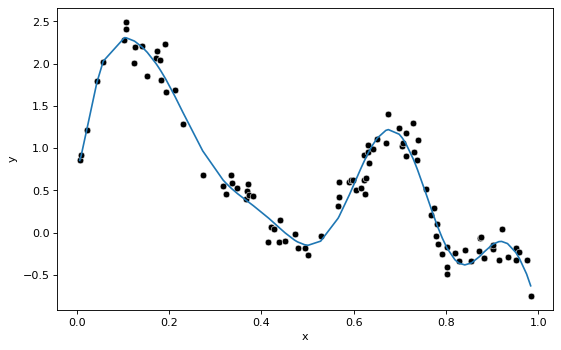

In [ ]:
sns.scatterplot(x='x', y='y', data=d, color="black")
sns.lineplot(
    x=d.x,
    y=grid_search.best_estimator_.predict(X)
)

---

### &diams; Exercise 7

Do these results appear to be "robust"? More specifically, do you think that the degree 13 polynomial model is actually the best? If you were to change the `random_state` used for the shuffling of the folds, will this result change?

*The $M=13$ model only seems marginally better than other models with slightly fewer degrees, it seems
quite likely that different folds might produce a different but similar answer for the optimal model.*

---

# 3. Additional dimensions and CV

Let us now consider an additive regression model of the following form,

$$ y = f(x_1) + g(x_2) + h(x_3) + \epsilon $$

where $f()$, $g()$, and $h()$ are polynomials with fix degrees, we will assume linear, quadratic and cubic in this case with the following coefficients:

$$
\begin{aligned}
f(x) &= 1.2 x + 1.1 \\
g(x) &= 2.5 x^2 - 0.9 x - 3.2  \\
h(x) &= 2 x^3 + 0.4 x^2 - 5.2 x + 2.7
\end{aligned}
$$

We generate values for $x_1$, $x_2$, $x_3$, and $\epsilon$ and then use these values to calculate observations of $y$ using the following code.


In [ ]:
np.random.seed(1234)
n = 500

f = lambda x: 1.2 * x + 1.1
g = lambda x: 2.5 * x**2 - 0.9 * x - 3.2 
h = lambda x: 2 * x**3 + 0.4 * x**2 - 5.2 * x + 2.7

ex2 = pd.DataFrame({
    "x1": np.random.rand(n),
    "x2": np.random.rand(n),
    "x3": np.random.rand(n)
}).assign(
   y = lambda d: f(d.x1) + g(d.x2) + h(d.x3) + 0.25*np.random.randn(n) # epsilon
)

print(ex2)

           x1        x2        x3         y
0    0.191519  0.883951  0.401106  0.207226
1    0.622109  0.741361  0.930614 -0.966704
2    0.437728  0.515711  0.515336 -0.899870
3    0.785359  0.135252  0.809582 -1.917369
4    0.779976  0.039884  0.881772 -1.179076
..        ...       ...       ...       ...
495  0.267568  0.995838  0.202188  1.562021
496  0.932827  0.944205  0.372405  1.223071
497  0.826145  0.131144  0.173656  0.741909
498  0.145443  0.518355  0.345234 -0.633376
499  0.647004  0.477245  0.567738 -0.833677

[500 rows x 4 columns]


---

### &diams; Exercise 8

Create a pairs plot of these data, from this alone is it possible to identify the polynomial relationships between $y$ and the $x$s?

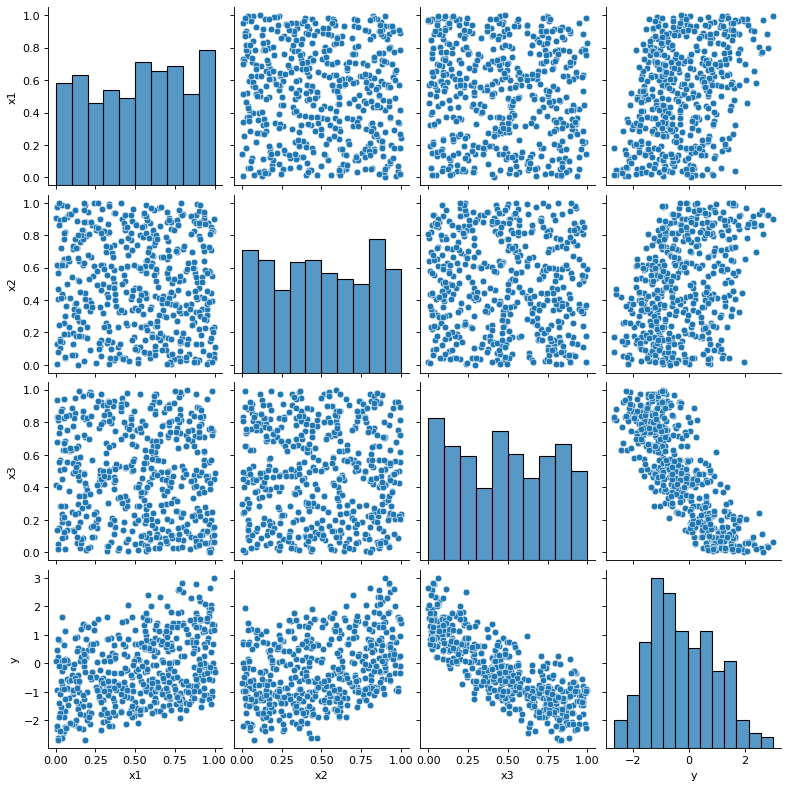

In [ ]:
sns.pairplot(ex2)

*There are no obvious relationships between $x_1$, $x_2$, or $x_3$ but it does appear 
that there are relationships between $y$ and $x_1$, $x_2$, and $x_3$ - although they all look 
somewhat weak and linear*.

---

We will assume that we know that each of the functions $f()$, $g()$, and $h()$ are at most of degree 3 - we can try to fit a polynomial model to these data using the tools we've seen thus far. 

In [ ]:
X = ex2.drop(columns=['y']) # Keep as a data frame not a nparray for later
y = ex2.y

In [ ]:
m = make_pipeline(
    PolynomialFeatures(degree=3),
    LinearRegression(fit_intercept=False)
)

fit = m.fit(X, y)

The following line prints out the model coefficients for the fitted model. While we may have expected only 10 (or 9) parameters in this model, we instead get 20 coefficients for this model.

In [ ]:
print( fit.named_steps['linearregression'].coef_ )

[ 0.28199407  2.32656568  0.20117018 -4.55915257 -1.10824194 -1.16081456
 -0.98352703  0.83509629 -0.48174047 -0.32581289  0.32341883  0.46312716
  0.55649515  0.53131633  0.12888933  0.34799729  0.66614765  0.52534563
  0.03664093  2.2074557 ]


The reason for this becomes more clear if we examine the `powers_` attribute which returns lists of the powers of $x_1$, $x_2$, and $x_3$ for each of the model terms. So for example the coeficient $0.282$ belongs to the $x_1^0 \, x_2^0 \, x_3^0$ term (i.e. the model intercept). 

In [ ]:
print( fit.named_steps['polynomialfeatures'].powers_ )

[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]
 [2 0 0]
 [1 1 0]
 [1 0 1]
 [0 2 0]
 [0 1 1]
 [0 0 2]
 [3 0 0]
 [2 1 0]
 [2 0 1]
 [1 2 0]
 [1 1 1]
 [1 0 2]
 [0 3 0]
 [0 2 1]
 [0 1 2]
 [0 0 3]]


---

### &diams; Exercise 10

Compare the fitted coefficients with the "true" values for our data, how close are they?

*There is almost no correspondence between the true model and our model.*

*The true model is*
$$
\begin{aligned}
f(x) &= 1.2 x + 1.1 \\
g(x) &= 2.5 x^2 - 0.9 x - 3.2  \\
h(x) &= 2 x^3 + 0.4 x^2 - 5.2 x + 2.7
\end{aligned}
$$

*The fitted model is*
$$
\begin{aligned}
\hat{y} =& 0.282  + \\
   & 2.327 x_1 - 1.108 x_1^2 + 0.323 x_1^3 + \\
   & 0.201 x_2 + 0.835 x_2^2 + 0.666 x_2^3 + \\
  -& 4.559 x_3 - 0.326 x_3^2 + 2.207 x_3^3 + \\
  -& 1.161 x_1 x_2 -0.984 x_1 x_3 -0.482 x_2 x_3 + \\
   & 0.463 x_1^2 x_2 +  0.556 x_1^2 x_3 +  0.531 x_1 x_2^2 + 0.348 x_1 x_3^2 + 0.525 x_2^2 x_3 + 0.037 x_2 x_3^2 \\
   & 0.129 x_1 x_2 x_3
\end{aligned}
$$


*Note that our model has $f(x_1)+ g(x_2)+h(x_3)$, therefore the overall intercept of the model should be: 
$1.1-3.2+2.7 = 0.6$*

---

### &diams; Exercise 11

Calculate the 5-fold cross validation rmse for this model.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv = cross_val_score(m, X, y, cv=kf, scoring="neg_root_mean_squared_error")
print(cv)
print(cv.mean())


[-0.26798009 -0.25624857 -0.23095929 -0.24516022 -0.267326  ]
-0.253534831926424


---

## 3.2 Column Transformers

For this particular model we do not want these interaction terms between our features, but this is not something that `sklearn` allows us to disable for `PolynomialFeatures`. This is actually a specific example of a more general issue where we do not want to apply a transformer to all of the features of a model at the same time. For this particularly example, we would like to apply an individual polynomial transformation to each of the three $x$. To do this we will use sklearn's `ColumnTransformer` and the `make_column_transformer` helper function from the `compose` submodule.

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_transformer

In [ ]:
ind_poly = make_column_transformer(
    (PolynomialFeatures(degree=3, include_bias=False), ['x1']),
    (PolynomialFeatures(degree=3, include_bias=False), ['x2']),
    (PolynomialFeatures(degree=3, include_bias=False), ['x3']),
)

The arguments for `make_column_transformer` are tuples of the desired transformer object and the name of the columns that will have that transformer applied. Once constructed the column transfomer works like any other transformer object and can be applied via `fit` and `transform` or `fit_transform` methods.

In [ ]:
trans = ind_poly.fit_transform(X, y)

In [ ]:
pd.DataFrame(trans) # printing as a DataFrame makes the array more readable

,0,1,2,3,4,5,6,7,8
0,0.191519,0.036680,0.007025,0.883951,0.781370,0.690693,0.401106,0.160886,0.064533
1,0.622109,0.387019,0.240768,0.741361,0.549615,0.407463,0.930614,0.866043,0.805952
2,0.437728,0.191606,0.083871,0.515711,0.265958,0.137157,0.515336,0.265571,0.136859
3,0.785359,0.616788,0.484400,0.135252,0.018293,0.002474,0.809582,0.655423,0.530619
4,0.779976,0.608362,0.474508,0.039884,0.001591,0.000063,0.881772,0.777522,0.685598
...,...,...,...,...,...,...,...,...,...
495,0.267568,0.071593,0.019156,0.995838,0.991694,0.987567,0.202188,0.040880,0.008265
496,0.932827,0.870166,0.811714,0.944205,0.891522,0.841779,0.372405,0.138686,0.051647
497,0.826145,0.682516,0.563857,0.131144,0.017199,0.002256,0.173656,0.030156,0.005237
498,0.145443,0.021154,0.003077,0.518355,0.268692,0.139278,0.345234,0.119186,0.041147


`ColumnTransformer`s are like `pipeline`s but they include a specific column or columns for the transformer to be applied. By using this transformer we take each feature and apply a single polynomial feature transformer, of degree 3 (excluding the intercept column (bias)), resulting in 9 total features as output (3 for each input feature). We can check these values make sense by examining them along with the original values of the $x$s. Here we are using `include_bias=False` to avoid creating a rank deficient model matrix, which would result if all three polynomial features transforms included the same intercept column.

In [ ]:
pd.concat([X, pd.DataFrame(trans)], axis=1)

,x1,x2,x3,0,1,2,3,4,5,6,7,8
0,0.191519,0.883951,0.401106,0.191519,0.036680,0.007025,0.883951,0.781370,0.690693,0.401106,0.160886,0.064533
1,0.622109,0.741361,0.930614,0.622109,0.387019,0.240768,0.741361,0.549615,0.407463,0.930614,0.866043,0.805952
2,0.437728,0.515711,0.515336,0.437728,0.191606,0.083871,0.515711,0.265958,0.137157,0.515336,0.265571,0.136859
3,0.785359,0.135252,0.809582,0.785359,0.616788,0.484400,0.135252,0.018293,0.002474,0.809582,0.655423,0.530619
4,0.779976,0.039884,0.881772,0.779976,0.608362,0.474508,0.039884,0.001591,0.000063,0.881772,0.777522,0.685598
...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.267568,0.995838,0.202188,0.267568,0.071593,0.019156,0.995838,0.991694,0.987567,0.202188,0.040880,0.008265
496,0.932827,0.944205,0.372405,0.932827,0.870166,0.811714,0.944205,0.891522,0.841779,0.372405,0.138686,0.051647
497,0.826145,0.131144,0.173656,0.826145,0.682516,0.563857,0.131144,0.017199,0.002256,0.173656,0.030156,0.005237
498,0.145443,0.518355,0.345234,0.145443,0.021154,0.003077,0.518355,0.268692,0.139278,0.345234,0.119186,0.041147


A `ColumnTransformer` is like any other transformer and can therefore be included in a pipeline, this enables us to create a pipeline for fitting our desired polynomial regression model (with no interaction terms). Since the polynomial features no longer include an intercept, we can add this back to the model with `fit_intercept=True` in the linear regression step.

In [ ]:
m2 = make_pipeline(
    make_column_transformer(
        (PolynomialFeatures(degree=3, include_bias=False), ['x1']),
        (PolynomialFeatures(degree=3, include_bias=False), ['x2']),
        (PolynomialFeatures(degree=3, include_bias=False), ['x3']),
    ),
    LinearRegression(fit_intercept=True)
)

fit = m2.fit(X, y)

We can examine the fitted values of the coefficients by accessing the `linearregression` step and its `coef_` and `intercept_` attributes.

In [ ]:
fit.named_steps['linearregression'].coef_

array([ 1.59319047, -0.60142411,  0.30713487, -0.47485212,  1.45500567,
        0.61273406, -4.97657888,  0.05251414,  2.07979504])

In [ ]:
fit.named_steps['linearregression'].intercept_

0.5121273713472773

Instead of directly fitting, we can also use this pipeline with cross validation functions like `cross_val_score` to obtain a more reliable estimate of our model's rmses.

In [ ]:
cv = cross_val_score(m2, X, y, cv=5, scoring="neg_root_mean_squared_error")

print(cv)
print(cv.mean())

[-0.26494573 -0.27297603 -0.23030777 -0.22129478 -0.2645753 ]
-0.25081992382431384


---

### &diams; Exercise 12

Is this rmse better or worse than the rmse calculated for the original model that included interactions? Explain why you think this is.

*The average rmse is very slightly better, the extra parameters from the interactions does not appear 
to have improved the overall model fit. This makes sense as $x_1$, $x_2$, and $x_3$ are independent.*

---

## 3.3 Column Transformers & CV Grid Search

Finally we will see if we can come close to recovering the original forms of $f()$, $g()$, and $h()$ using `GridSearchCV`.  This builds on our previous use of this function, but now we need to optimize over the degree parameter of all three of the polynomial feature transformers. We can examine the names of these transforms by examining the `named_transformers_` attribute associated with the `columntransformer`,

In [ ]:
m2.named_steps['columntransformer'].named_transformers_

{'polynomialfeatures-1': PolynomialFeatures(degree=3, include_bias=False),
 'polynomialfeatures-2': PolynomialFeatures(degree=3, include_bias=False),
 'polynomialfeatures-3': PolynomialFeatures(degree=3, include_bias=False)}

This gives us the transformer names: `polynomialfeatures-1`, `polynomialfeatures-2`, and `polynomialfeatures-3` which are referenced in the same way by combining the step name with the transformer name and then the parameter name separated by `__`. As such, the degree parameter for the first transformer will be `columntransformer__polynomialfeatures-1__degree`. It is also possible to view all of the parameters for a model or pipeline by looking at the keys returns by the `get_params` method.

In [ ]:
m2.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'linearregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__polynomialfeatures-1', 'columntransformer__polynomialfeatures-2', 'columntransformer__polynomialfeatures-3', 'columntransformer__polynomialfeatures-1__degree', 'columntransformer__polynomialfeatures-1__include_bias', 'columntransformer__polynomialfeatures-1__interaction_only', 'columntransformer__polynomialfeatures-1__order', 'columntransformer__polynomialfeatures-2__degree', 'columntransformer__polynomialfeatures-2__include_bias', 'columntransformer__polynomialfeatures-2__interaction_only', 'columntransformer__polynomialfeatures-2__order', 'columntransformer__polynomialfeatures-3__degree', 'columntransformer__polynomialfeatures-3__include_bias', 'columntransformer__polynomialfeatur

To keep the space of parameters being explored reasonable we will restrict the possible value of the degrees parameter to be in $[1,\ldots,5]$. This may take a little bit as we are now fitting a decently large number of models.

In [ ]:
parameters = {
    'columntransformer__polynomialfeatures-1__degree': np.arange(1,5,1),
    'columntransformer__polynomialfeatures-2__degree': np.arange(1,5,1),
    'columntransformer__polynomialfeatures-3__degree': np.arange(1,5,1),
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(m2, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X, y)

---

### &diams; Exercise 13

How many models have been fit and scored by `GridSearchCV`?

*The code as provided actually only fits models with degrees between 1 and 4 so in that case
we are testing $4 \times 4 \times 4$ different degree values, and for each there are 5 folds - so 
there are $4^3 * 5 = 320$ models being fit.*

*If we had correctly set the parameter ranges to $[1,2,3,4,5]$ then there would have been $5^4 = 625$ models fit.*



---

Once fit, we can determine the optimal parameter value by accessing `grid_search`'s attributes,

In [ ]:
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

best index:  10
best param:  {'columntransformer__polynomialfeatures-1__degree': 1, 'columntransformer__polynomialfeatures-2__degree': 3, 'columntransformer__polynomialfeatures-3__degree': 3}
best score:  -0.24827845229249973


---

### &diams; Exercise 14

Based on these results have we done a good job of recovering the general structure of the functions $f()$, $g()$, and $h()$? e.g. have we correctly recovered the degrees of these functions.

*The recovered model is reasonably close to the true model - $f(x)$ is linear, $g(x)$ and $h(x)$ are cubic.*

---

We can directly access the properties of the "best" model, according to our scoring method, using the `best_estimator_` attribute. From this we can access the `linearregression` step of the pipeline to recover the model coefficients.

In [ ]:
grid_search.best_estimator_.named_steps["linearregression"].intercept_

0.547234949864674

In [ ]:
grid_search.best_estimator_.named_steps["linearregression"].coef_

array([ 1.26880491e+00, -4.80356378e-01,  1.47923181e+00,  5.92674399e-01,
       -4.95420711e+00,  2.40266994e-03,  2.11215152e+00])

---

### &diams; Exercise 15

Compare the coefficient values we obtained via `GridSearchCV` to the true values used to generate the $y$ observations, how well have recovered the truth values of the coefficients?

*While not exactly correct, these values are much closer to the true model than our previous attempt.*

*The true model is:*
$$
\begin{aligned}
f(x) &= 1.2 x + 1.1 \\
g(x) &= 2.5 x^2 - 0.9 x - 3.2  \\
h(x) &= 2 x^3 + 0.4 x^2 - 5.2 x + 2.7
\end{aligned}
$$


*The predicted model is:*
$$
\begin{aligned}
\hat{y} = & 0.547 + \\
          & 1.269x_1 + \\ 
         -& 0.480 x_2 + 1.479 x_2^2 +  0.593 x_2^3 + \\
         -& 4.954 x_3 + 0.002 x_3^2 +  2.112 x_3^3
\end{aligned}
$$



---

## 4. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF and turn it in on gradescope under the `mlp-week04` assignment.

In [ ]:
!jupyter nbconvert --to pdf mlp-week04.ipynb

[NbConvertApp] Converting notebook mlp-week04.ipynb to pdf
[NbConvertApp] Support files will be in mlp-week04_files/
[NbConvertApp] Making directory ./mlp-week04_files
[NbConvertApp] Making directory ./mlp-week04_files
[NbConvertApp] Making directory ./mlp-week04_files
[NbConvertApp] Making directory ./mlp-week04_files
[NbConvertApp] Making directory ./mlp-week04_files
[NbConvertApp] Making directory ./mlp-week04_files
[NbConvertApp] Writing 95147 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 439566 bytes to mlp-week04.pdf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0da86d75-479e-4f01-8931-f4f109181a50' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>